In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [114]:
class N_Armed_Bandit():
    
    def __init__(self,game,play,
                 n_arms,control_paras,
                 burning_period=1,
                 step_size = None,
                 selection_method='softmax',
                 incre_implem=0):
        
        # times of game
        self.game = game
        
        # times of playround during each game
        self.play = play
        
        # how many levers
        self.n_arms = n_arms
        
        # epsilon for epsilon-greedy, tau(tempreture) for softmax
        self.control_paras = control_paras
        
        # how many rounds of burning period are included during the simulation
        self.burning_period = burning_period
        
        # n_unique of control_paras decisdes how many methods are competing
        self.n_group = len(control_paras)
        
        # which method to select action
        self.selection_method = selection_method
        
        # whether use incremental implementation
        self.incre_implem = incre_implem
        
        # whether the state goes stationary, if None, means this is a stationary problem
        self.step_size = step_size
        
    def __DataRestoration(self):
        
        # True rewards, fixed for each game
        self.true_rwd = np.random.normal(0,1,self.n_arms)
        self.best_action = np.argmax(self.true_rwd)
        
        # Estimated reward, update after each play
        self.estimated_rwd = np.zeros((self.n_group,self.n_arms))
        
        # Record total reward of each action, update after each play
        self.acc_action_rwd = np.zeros((self.n_group,self.n_arms))           
        
        # Track the times each action taken, used for update estimated reward when incre_implem=0, 
        # and for calculate optimal_choice%
        self.action_times = np.zeros((self.n_group,self.n_arms))
        
        # Track the optimal action taken percentage in each playround
        self.optimal_taken_percentage = np.zeros((self.n_group,self.play))

        # Track the accumulated reward during the play
        self.acc_rwd_track = np.zeros((self.n_group,self.play))   
        
        # Track the greedy action reward in each playround
        self.greedy_action_rwd_track = np.zeros((self.n_group,self.play))
        
    def Softmax_selection(self,Q_t):
        
        # reshape paras, to adapt numpy array computation
        tau = np.array(self.control_paras).reshape(self.n_group,-1)
        
        numerator = np.exp(Q_t/tau)
        denominator = numerator.sum(axis=1,keepdims=True)
        softmax_prob = numerator/denominator
        
        a=[]
        exploiting=[]
        
        for i in range(self.n_group):
                    
            a_temp = np.random.choice(list(range(self.n_arms)),p=softmax_prob[i,:])
            exploiting_temp = int(np.argmax(softmax_prob[i,:]))
            
            a.append(a_temp)
            exploiting.append(exploiting_temp)
            
        return a,exploiting
     
    def Epsilon_greedy_selection(self,Q_t):

        greedy_prob = np.random.uniform(0,1)
        a = []
        exploiting = []
        
        for i in range(self.n_group):

            if self.control_paras[i]==0:
                a_temp = int(np.argmax(self.estimated_rwd[i,:]))
                exploiting_temp = a_temp
                a.append(a_temp)
                exploiting.append(exploiting_temp)
            else:
                exploring = list(range(self.n_arms))
                exploiting_temp = np.argmax(self.estimated_rwd[i,:])
                exploring.remove(exploiting_temp)
                a_temp = int((greedy_prob<=self.control_paras[i])*np.random.choice(exploring))+int((greedy_prob>self.control_paras[i])*exploiting_temp)
                a.append(a_temp)
                exploiting.append(exploiting_temp)
                
        return a,exploiting
              
    def Choose_action(self,p):
        
        # Strategy During Burning Period
        if p < self.burning_period:
            
            a = np.random.randint(0,self.n_arms,self.n_group)
            exploiting = a
            
        # Strategy After Burning Period
        else:
            
            # Softmax Action Selection
            # ------------------------
            if self.selection_method=='softmax':
                
                a,exploiting = self.Softmax_selection(self.estimated_rwd)
                
            # Epsilon-Greedy Strategy 
            # ------------------------
            if self.selection_method=='epsilon':
                
                a,exploiting = self.Epsilon_greedy_selection(self.estimated_rwd)
                
        return a,exploiting
    
    def Update_Rewards(self,a,p,exploiting):
        
        for i in range(self.n_group):

            # update action times taken
            self.action_times[i,a[i]] += 1
            
            current_reward = np.random.normal(self.true_rwd[a[i]],1)
            
            if self.incre_implem==0:
                # update accumulated rewards of each action
                self.acc_action_rwd[i,a[i]] += current_reward

                # update estimated reward of each action
                self.estimated_rwd[i,a[i]] = self.acc_action_rwd[i,a[i]]/self.action_times[i,a[i]]
                
            if self.incre_implem==1:
                
                self.acc_action_rwd[i,a[i]] += current_reward
                
                if self.step_size == None:
                    self.estimated_rwd[i,a[i]] = self.estimated_rwd[i,a[i]]/(1+self.action_times[i,a[i]]) + (current_reward-self.estimated_rwd[i,a[i]])/(1+self.action_times[i,a[i]])
                else:
                    self.estimated_rwd[i,a[i]] = self.estimated_rwd[i,a[i]] + self.step_size*(current_reward-self.estimated_rwd[i,a[i]])
                
        # record the accumulated reward
        self.acc_rwd_track[:,p] = self.acc_action_rwd.sum(axis=1)/(p+1)
        
    def Track_Greedy(self,a,p,exploiting):
        
        for i in range(self.n_group):
            
            if p==0:
                # update optimal action reward
                self.greedy_action_rwd_track[i,p] = np.random.normal(self.true_rwd[exploiting[i]],1)
            else:
                self.greedy_action_rwd_track[i,p] = (p*(self.greedy_action_rwd_track[i,p-1])+np.random.normal(self.true_rwd[exploiting[i]],1))/(p+1) 
                
    def Track_Optimal(self,p):
        
        for i in range(self.n_group):
            
            self.optimal_taken_percentage[i,p] = self.action_times[i,self.best_action]/(p+1)
    
    def ReadyPlayer(self):
        
        # Track the accumulated reward after each game
        self.total_game_rwd_track = np.zeros((self.n_group,self.play))  
        
        # Track the accumulated reward after each game
        self.total_greedy_action_rwd_track = np.zeros((self.n_group,self.play)) 
        
        # Track the accumulated best action taken percentage after each game
        self.total_optimal_taken_percentage = np.zeros((self.n_group,self.play)) 
        
        for g in range(self.game):
            
            start = time.time()
            
            # each game need new data restoration
            self.__DataRestoration()
            
            for p in range(self.play):
                
                a,exploiting=self.Choose_action(p)
                self.Update_Rewards(a,p,exploiting)
                self.Track_Greedy(a,p,exploiting)
                self.Track_Optimal(p)
                
            self.total_game_rwd_track += self.acc_rwd_track  
            self.total_greedy_action_rwd_track += self.greedy_action_rwd_track
            self.total_optimal_taken_percentage += self.optimal_taken_percentage
            
            end = time.time()
            print('game{} finished, time cost {}seconds'.format(g,np.round(end-start,4)))
            
        self.total_game_rwd_track = self.total_game_rwd_track/self.game
        self.total_greedy_action_rwd_track = self.total_greedy_action_rwd_track/self.game
        self.total_optimal_taken_percentage = self.total_optimal_taken_percentage/self.game
        
        self.reward_data = pd.DataFrame(self.total_game_rwd_track[:,self.burning_period:]).T
        self.greedy_action = pd.DataFrame(self.total_greedy_action_rwd_track[:,self.burning_period:]).T
        self.optimal_taken = pd.DataFrame(self.total_optimal_taken_percentage[:,self.burning_period:]).T
        
        if self.selection_method=='softmax':
            self.reward_data.columns = ['tau='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['tau='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['tau='+str(i) for i in self.control_paras]
            
        if self.selection_method=='epsilon':
            self.reward_data.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['epsilon='+str(i) for i in self.control_paras]

In [121]:
# Epsilon-Greedy Strategy
RP1 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0,0.01,0.1,0.3,0.5],burning_period=1,
                     selection_method='epsilon',incre_implem=0)
# Softmax Strategy
RP2 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0.01,0.1,0.5,1,2],burning_period=1,
                     selection_method='softmax',incre_implem=0)

In [122]:
RP1.ReadyPlayer()

game0 finished, time cost 0.911seconds
game1 finished, time cost 1.0205seconds
game2 finished, time cost 0.9352seconds
game3 finished, time cost 0.9852seconds
game4 finished, time cost 0.9507seconds
game5 finished, time cost 0.9534seconds
game6 finished, time cost 0.9771seconds
game7 finished, time cost 0.9615seconds
game8 finished, time cost 1.1971seconds
game9 finished, time cost 0.9355seconds
game10 finished, time cost 0.9543seconds
game11 finished, time cost 0.9292seconds
game12 finished, time cost 0.9723seconds
game13 finished, time cost 0.9485seconds
game14 finished, time cost 0.963seconds
game15 finished, time cost 1.2419seconds
game16 finished, time cost 0.9401seconds
game17 finished, time cost 0.9394seconds
game18 finished, time cost 0.9603seconds
game19 finished, time cost 0.9461seconds
game20 finished, time cost 0.9386seconds
game21 finished, time cost 0.9468seconds
game22 finished, time cost 0.9829seconds
game23 finished, time cost 0.9563seconds
game24 finished, time cost 0

In [123]:
RP2.ReadyPlayer()

game0 finished, time cost 1.241seconds
game1 finished, time cost 1.3252seconds
game2 finished, time cost 1.3296seconds
game3 finished, time cost 1.3291seconds
game4 finished, time cost 1.234seconds
game5 finished, time cost 1.3194seconds
game6 finished, time cost 1.3305seconds
game7 finished, time cost 1.3203seconds
game8 finished, time cost 1.3362seconds
game9 finished, time cost 1.2757seconds
game10 finished, time cost 1.3106seconds
game11 finished, time cost 1.7066seconds
game12 finished, time cost 1.3506seconds
game13 finished, time cost 1.3342seconds
game14 finished, time cost 1.3099seconds
game15 finished, time cost 1.6124seconds
game16 finished, time cost 1.2677seconds
game17 finished, time cost 1.3345seconds
game18 finished, time cost 1.3275seconds
game19 finished, time cost 1.3954seconds
game20 finished, time cost 1.332seconds
game21 finished, time cost 1.3282seconds
game22 finished, time cost 1.3096seconds
game23 finished, time cost 1.3233seconds
game24 finished, time cost 1.

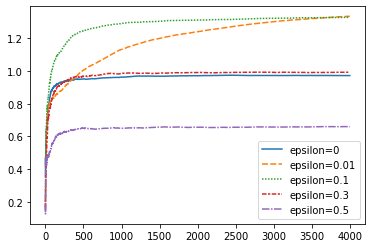

In [124]:
# Epsilon-greedy strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure()
sns.lineplot(data = RP1.reward_data)

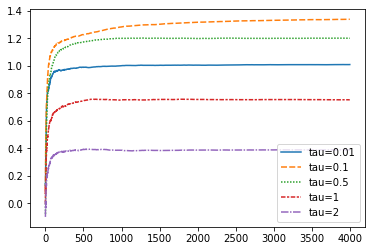

In [125]:
# Softmax strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure()
sns.lineplot(data = RP2.reward_data)

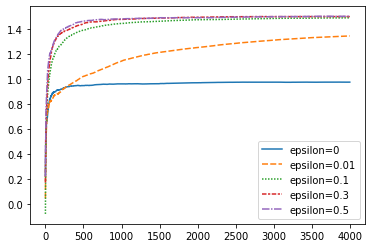

In [126]:
# Epsilon-greedy strategy, total average rewards under greedy action selection
plt.figure()
sns.lineplot(data = RP1.greedy_action)

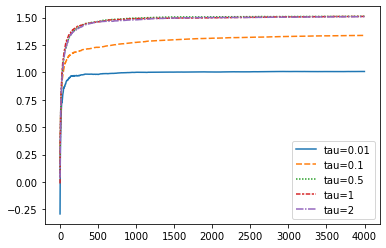

In [127]:
# Softmax strategy, total average rewards under greedy action selection
plt.figure()
sns.lineplot(data = RP2.greedy_action)

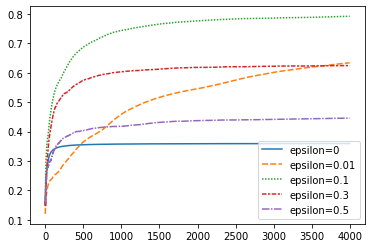

In [128]:
# Epsilon-greedy strategy, optimal actions taken percentage
plt.figure()
sns.lineplot(data = RP1.optimal_taken)

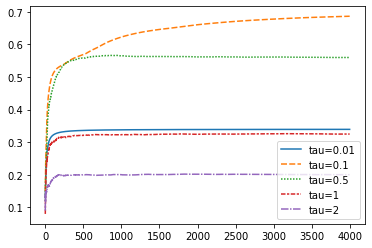

In [129]:
# Softmax strategy, optimal actions taken percentage
plt.figure()
sns.lineplot(data = RP2.optimal_taken)